**Transfer Learning via Xception model (Dogs vs. Cats)**

* Part 1 [Intro to CNN (Dogs vs. Cats)](https://www.kaggle.com/imcr00z/intro-to-cnn-dogs-vs-cats)
* Part 2 [Intro to CNN: Augmentation & Dropout](https://www.kaggle.com/imcr00z/intro-to-cnn-augmentation-dropout)
* Part 3 [Transfer Learning (Dogs vs. Cats) 98% acc.](https://www.kaggle.com/imcr00z/transfer-learning-dogs-vs-cats-98-acc)

In this part i use transfer learning and pretrained models:
* Xception (from Franc¸ois Chollet). Original document [here](https://arxiv.org/pdf/1610.02357.pdf)
* MobileNet via Google. Original document [here](https://arxiv.org/pdf/1704.04861.pdf)

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import tqdm

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# Load data

In [3]:
CONTENT_DIR = '/kaggle/content'
TRAIN_DIR = CONTENT_DIR + '/train'
VALID_DIR = CONTENT_DIR + '/valid'

if not os.path.exists(CONTENT_DIR):
    # Extract dataset
    import zipfile
    with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zipf:
        zipf.extractall(CONTENT_DIR)

    # Split cats and dogs images to train and valid datasets
    img_filenames = os.listdir(TRAIN_DIR)
    dog_filenames = [fn for fn in img_filenames if fn.startswith('dog')]
    cat_filenames = [fn for fn in img_filenames if fn.startswith('cat')]
    dataset_filenames = train_test_split(
        dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
    )

    # Move images
    make_dirs = [d + a for a in ['/dog', '/cat'] for d in [TRAIN_DIR, VALID_DIR]]
    for dir, fns in zip(make_dirs, dataset_filenames):
        os.makedirs(dir, exist_ok=True)
        for fn in tqdm.tqdm(fns):
            shutil.move(os.path.join(TRAIN_DIR, fn), dir)
        print('elements in {}: {}'.format(dir, len(os.listdir(dir))))

100%|██████████| 11250/11250 [00:00<00:00, 16392.92it/s]


elements in /kaggle/content/train/dog: 11250


100%|██████████| 1250/1250 [00:00<00:00, 14563.76it/s]


elements in /kaggle/content/valid/dog: 1250


100%|██████████| 11250/11250 [00:00<00:00, 14959.75it/s]


elements in /kaggle/content/train/cat: 11250


100%|██████████| 1250/1250 [00:00<00:00, 13081.56it/s]

elements in /kaggle/content/valid/cat: 1250


In [4]:
BATCH_SIZE = 32
IMAGE_SHAPE = 128

# Preprocessing

In [5]:
# make data generators
train_generator = ImageDataGenerator(rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255)
train_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
valid_data = valid_generator.flow_from_directory(
    directory=VALID_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Xception
In this part, I extract 'bottleneck features' from an Xception model without fully connected layers and train a new fully connected model on them.
1. load and train xception, get bottleneck features
2. create model with dense layers
3. train dense layers on bottleneck features

In [6]:
# load xception model
xception_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)

2021-11-21 06:31:28.847845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 06:31:29.030451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 06:31:29.031326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 06:31:29.032516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


In [7]:
# look at this, it's very scary :)
# change include_top=True -> last layer added
# tf.keras.utils.plot_model(xception_model, dpi=48, show_shapes=True)

In [8]:
# bottleneck features for train dataset
train_bottleneck = xception_model.predict_generator(
    train_data, train_data.n // BATCH_SIZE, verbose=1
)
# np.save(open('train_bottleneck.np', 'wb'), train_bottleneck)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2021-11-21 06:31:33.148375: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-21 06:31:34.607393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


703/703 [==============================] - 65s 83ms/step


In [9]:
# bottleneck features for valid dataset
valid_bottleneck = xception_model.predict_generator(
    valid_data, valid_data.n // BATCH_SIZE, verbose=1
)
# np.save(open('valid_bottleneck.np', 'wb'), valid_bottleneck)

78/78 [==============================] - 6s 78ms/step


In [10]:
# create simple model for classification
model = tf.keras.models.Sequential([
    Dense(units=256, activation='relu', input_shape=xception_model.output_shape[1:]),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 557,698
Trainable params: 557,698
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# get predicted features and classify it
EPOCHS = 10
history = model.fit(
    x=train_bottleneck,
    y=train_data.labels[:len(train_bottleneck)],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_bottleneck, valid_data.labels[:len(valid_bottleneck)])
)

Epoch 1/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1804 - accuracy: 0.9266 - val_loss: 0.1387 - val_accuracy: 0.9399
Epoch 2/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1338 - accuracy: 0.9446 - val_loss: 0.1370 - val_accuracy: 0.9383
Epoch 3/10
703/703 [==============================] - 1s 2ms/step - loss: 0.1246 - accuracy: 0.9479 - val_loss: 0.1314 - val_accuracy: 0.9407
Epoch 4/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1168 - accuracy: 0.9536 - val_loss: 0.1274 - val_accuracy: 0.9475
Epoch 5/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1084 - accuracy: 0.9573 - val_loss: 0.1340 - val_accuracy: 0.9487
Epoch 6/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1064 - accuracy: 0.9587 - val_loss: 0.1376 - val_accuracy: 0.9455
Epoch 7/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1008 - accuracy: 0.9603 - val_loss: 0.1347 - val_accuracy: 0.9447
Epoch 

Look to validation loss and accuracy.

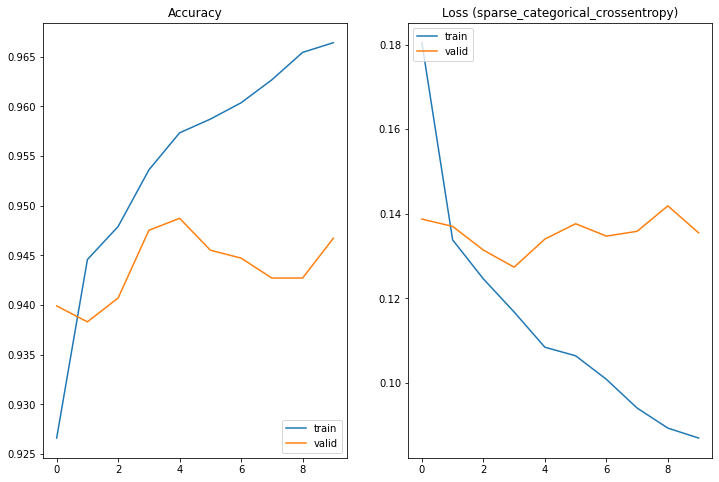

In [14]:
def show_graphs(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend(loc='upper left')
    plt.title('Loss (sparse_categorical_crossentropy)')

    plt.show()
    
show_graphs(history)

# MobileNet
In this case i use classical path with frozen layers.

In [15]:
mobilenet_model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)
mobilenet_model.trainable = False # freeze convolutional layers

17235968/17225924 [==============================] - 0s 0us/step


In [16]:
# new fully connected part of the network
dense_model = tf.keras.models.Sequential([
    Dense(units=1000, activation='relu'),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

In [17]:
# build a new model
model2 = tf.keras.models.Sequential([
    mobilenet_model,
    dense_model
])

In [18]:
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
EPOCHS = 10
train_data.reset()
valid_data.reset()
history = model2.fit_generator(
    train_data,
    steps_per_epoch=train_data.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_data,
    validation_steps=valid_data.n // BATCH_SIZE
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
703/703 [==============================] - 65s 90ms/step - loss: 0.1650 - accuracy: 0.9479 - val_loss: 0.1016 - val_accuracy: 0.9671
Epoch 2/10
703/703 [==============================] - 64s 91ms/step - loss: 0.0853 - accuracy: 0.9693 - val_loss: 0.0756 - val_accuracy: 0.9667
Epoch 3/10
703/703 [==============================] - 65s 92ms/step - loss: 0.0728 - accuracy: 0.9730 - val_loss: 0.1083 - val_accuracy: 0.9675
Epoch 4/10
703/703 [==============================] - 64s 90ms/step - loss: 0.0664 - accuracy: 0.9759 - val_loss: 0.0730 - val_accuracy: 0.9740
Epoch 5/10
703/703 [==============================] - 64s 91ms/step - loss: 0.0587 - accuracy: 0.9794 - val_loss: 0.0775 - val_accuracy: 0.9675
Epoch 6/10
703/703 [==============================] - 64s 91ms/step - loss: 0.0560 - accuracy: 0.9797 - val_loss: 0.0935 - val_accuracy: 0.9631
Epoch 7/10
703/703 [==============================] - 65s 92ms/step - loss: 0.0489 - accuracy: 0.9812 - val_loss: 0.0886 - val_accuracy:

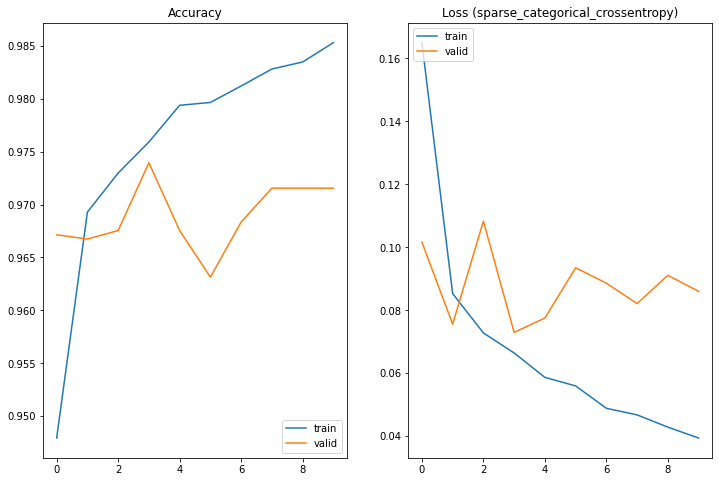

In [20]:
show_graphs(history)

# MobileNet with native output layer

Only for fun :)

**Achtung! Attention! Vnimanie!** If your datasets don't match very well, that's a bad idea!

In [21]:
IMAGE_SHAPE = 224
example_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)
example_x, example_y = example_data.next()
example_classes = list(example_data.class_indices.keys())
example_y_classes = [example_classes[int(i)] for i in example_y]

Found 22500 images belonging to 2 classes.


In [22]:
mobilenet_native = tf.keras.applications.mobilenet.MobileNet(
    include_top=True,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)
mobilenet_native.compile()
example_pred = mobilenet_native.predict(
    example_x
)

17235968/17225924 [==============================] - 0s 0us/step


In [23]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
)
imagenet_labels = np.array(open(labels_path).read().splitlines())
result = imagenet_labels[np.argmax(example_pred, axis=1)]

24576/10484 [======================================================================] - 0s 0us/step


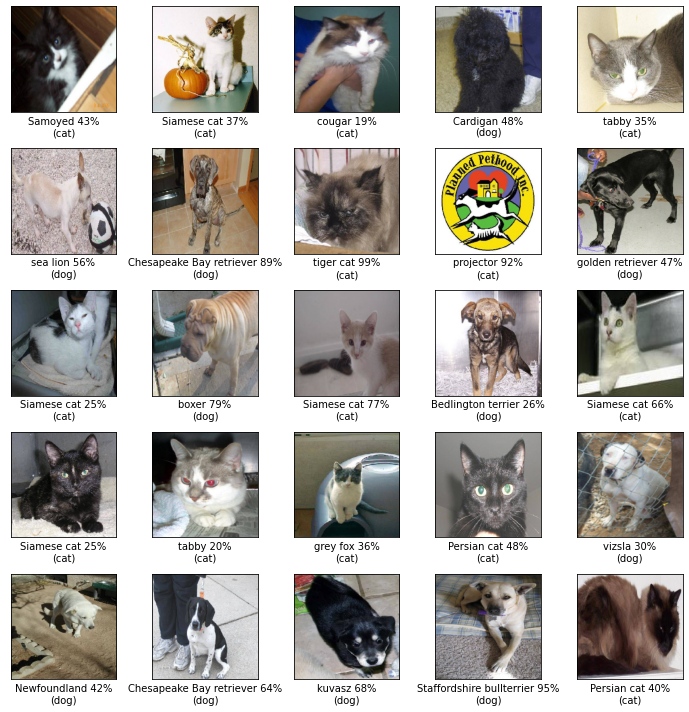

In [24]:
NUM_ROWS = 5
NUM_COLS = 5
NUM_IMAGES = NUM_COLS * NUM_ROWS
plt.figure(figsize=(2*NUM_COLS, 2*NUM_ROWS))
for i in range(NUM_IMAGES):
    plt.subplot(NUM_ROWS, NUM_COLS, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(example_x[i], cmap=plt.cm.binary)
    plt.xlabel('{} {:.0%}\n({})'.format(result[i], np.max(example_pred[i]), example_y_classes[i]))
plt.tight_layout()
plt.show()